### **STEAM DATASET EDA**

This script contains an analysis of the **2021 STEAM reviews dataset**, which contains raw information concerning the reviews received by video games on the Steam platform. In particular, the dataset provides us with clues on the preferred writing times of reviewers, their languages and popularity. 

Throughout our analysis, we tried to convert this information into valuable knowledge, which could be used to understand what players enjoy and appreciate (or, vice versa, criticize) in a game. 

**Note**: In addition to the Kaggle dataframe, both the extensions provided have been used in this notebook. That is, the results presented refer to the data contained in three merged datasets (*dfs*), called, respectively, *df* (Kaggle dataframe), *ext1* and *ext2* (extensions).

# **Upload Dataset**

In [ ]:
# Import useful libraries

# connect to Google Drive to load extensions
from google.colab import drive 
drive.mount('/content/drive/')


# to work on dataframes
import pandas as pd
import numpy as np
from datetime import timedelta
# to clear some RAM
import gc

# for plotting
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

# import statsmodels 
from scipy.stats import mannwhitneyu, kruskal
from scipy import stats
from sklearn import preprocessing
import statsmodels.api as sm 
import random


In [ ]:
# due to RAM constraints, we only upload the columns needed for our analysis

useful_cols = ["app_id", "review_id","app_name",  "language", "timestamp_created", "timestamp_updated",           
"recommended",                               
"votes_helpful",                              
"votes_funny",                                        
"weighted_vote_score",                    
"received_for_free",                       
"steam_purchase",
"author.steamid",                             
"author.num_reviews",
"author.playtime_at_review"]

**In order to avoid the download of the dataset from kaggle, and the running of the code on our machine, the following 8 lines of code connect directly Colab and Kaggle**

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload() #here is required the personal kaggle's API TOKEN (from account settings in kaggle, the format of the file is ".json")

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jacoponudo","key":"04b63962d3875c46fdff534bec920cf4"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d najzeko/steam-reviews-2021

100% 2.97G/2.97G [01:09<00:00, 50.1MB/s]
100% 2.97G/2.97G [01:09<00:00, 45.8MB/s]


In [ ]:
!unzip steam-reviews-2021.zip

Archive:  steam-reviews-2021.zip
  inflating: steam_reviews.csv       


In [ ]:
import functions as f

ModuleNotFoundError: ignored

In [ ]:
# load dataset from Kaggle
df = pd.read_csv("steam_reviews.csv", usecols = useful_cols, 
               parse_dates=['timestamp_created', 'timestamp_updated'],
               date_parser=f.dateparse)

NameError: ignored

In [ ]:
# load first extension
ext1 = pd.read_csv("/content/drive/MyDrive/steam_reviews_bonus_1.csv", usecols = useful_cols, 
               parse_dates=['timestamp_created', "timestamp_updated"], skiprows=[234060, 5938492, 8278792, 9163394],
               date_parser=f.dateparse)

# note: certain rows have been omitted as in the "timestamp_updated" column they contained boolean values (True or False) instead of actual times.

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (9,14,15) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
# load second extension
ext2 = pd.read_csv("/content/drive/MyDrive/steam_reviews_bonus_2.csv",  usecols = useful_cols, 
               parse_dates=['timestamp_created', 'timestamp_updated'], skiprows=[3895921, 3984228, 5893390, 1929921],
               date_parser=f.dateparse)

# note: also here certain rows have been omitted as in the "timestamp_updated" column they contained boolean values (True or False) instead of actual times.

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (9,14,15) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
dfs = pd.concat([df, ext1, ext2], ignore_index=True)

In [ ]:
# to clear some RAM

del [[df,ext1, ext2]]

gc.collect()
df=pd.DataFrame()
ext1=pd.DataFrame()
ext2 = pd.DataFrame()

In [ ]:
dfs.shape

(38747371, 15)

Our dataset is considerably large, with more than 38 million entries and 15 columns. Some precautions must be taken in order not to exceed the RAM (25.46 GB) like, for example, deleting variables that are not needes anymore (as done above through Python's garbage collector, which freed some much needed space).

\\

# **[RQ1] - EDA**

We start our study of the Steam Dataset with some Exploratory Data Analysis to find insight about gamers' reviews.

In [ ]:
dfs.select_dtypes(include = ['float64', 'int64']).head() #select only numeric columns 

,app_id,review_id,votes_helpful,votes_funny,weighted_vote_score,author.steamid,author.num_reviews,author.playtime_at_review
0,292030,85185598,0.0,0.0,0.0,7.656120e+16,2.0,1909.0
1,292030,85185250,0.0,0.0,0.0,7.656120e+16,10.0,2674.0
2,292030,85185111,0.0,0.0,0.0,7.656120e+16,1.0,1060.0
3,292030,85184605,0.0,0.0,0.0,7.656120e+16,3.0,5524.0
4,292030,85184287,0.0,0.0,0.0,7.656120e+16,4.0,217.0


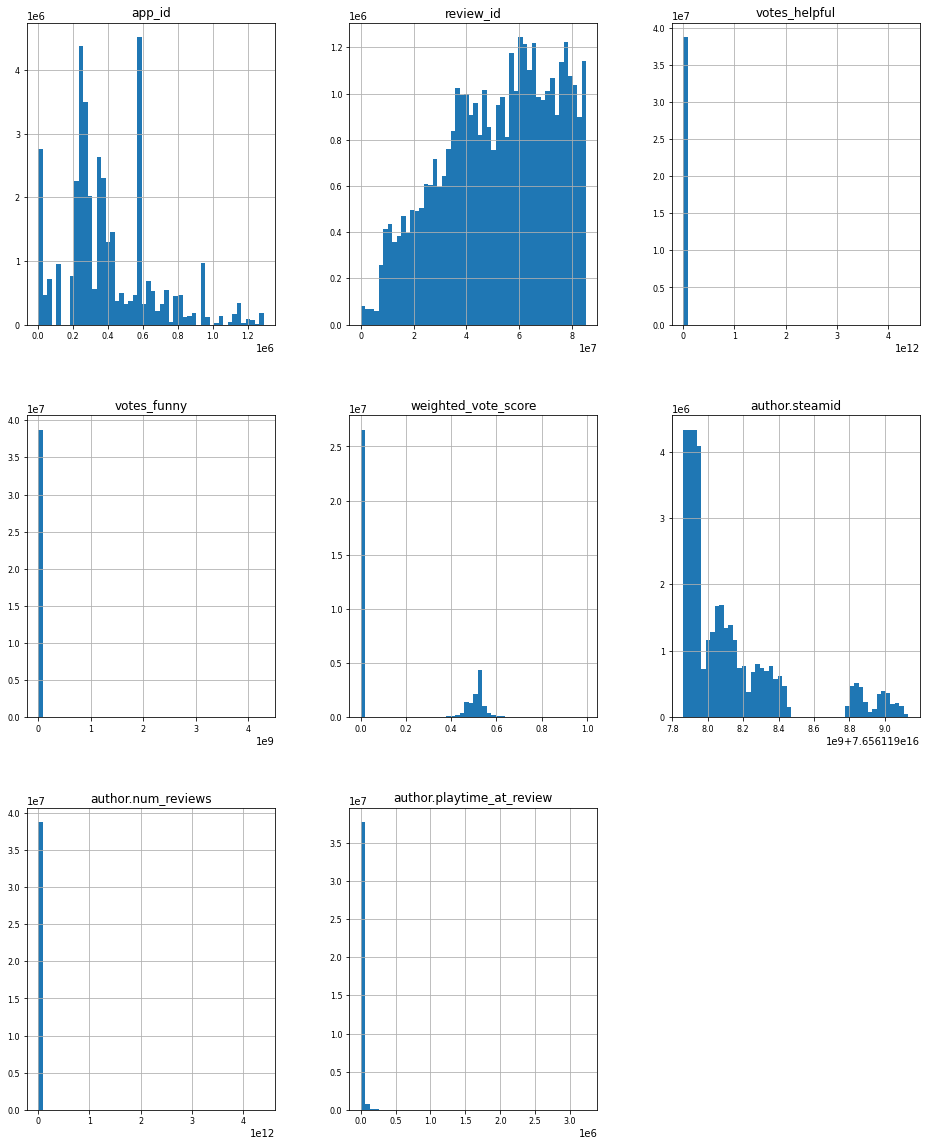

In [ ]:
dfs.select_dtypes(include = ['float64', 'int64']).hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8) # plot histograms of numeric columns
plt.show()

The histograms show that we don't have a lot of variability in the data, apart from the  *app_id*, *review_id* and *author.steamid* features, which - however - should be treated like strings and not like numbers, as they solely identify an app, review or author and add no meaning to our analysis.

\\



In [ ]:
dfs.describe()

,app_id,review_id,votes_helpful,votes_funny,weighted_vote_score,author.steamid,author.num_reviews,author.playtime_at_review
count,3.874737e+07,3.874737e+07,3.874736e+07,3.874736e+07,3.874736e+07,3.874736e+07,3.874736e+07,3.870170e+07
mean,3.974891e+05,5.206594e+07,4.540246e+05,1.203789e+05,1.623329e-01,7.656120e+16,4.540331e+05,8.974073e+03
std,2.546857e+05,2.091446e+07,1.413086e+09,2.273776e+07,2.421254e-01,3.082854e+08,1.413086e+09,2.421316e+04
min,7.000000e+01,4.300000e+01,0.000000e+00,0.000000e+00,0.000000e+00,7.656120e+16,1.000000e+00,1.000000e+00
25%,2.509000e+05,3.658357e+07,0.000000e+00,0.000000e+00,0.000000e+00,7.656120e+16,2.000000e+00,5.540000e+02
50%,3.595500e+05,5.427064e+07,0.000000e+00,0.000000e+00,0.000000e+00,7.656120e+16,4.000000e+00,1.870000e+03
75%,5.780800e+05,6.955756e+07,1.000000e+00,0.000000e+00,4.800000e-01,7.656120e+16,9.000000e+00,6.941000e+03
max,1.291340e+06,8.521867e+07,4.398047e+12,4.294967e+09,9.959868e-01,7.656120e+16,4.398047e+12,3.228103e+06


The **describe()** operation confirms what we see in the histograms above: variables like *votes_helpful*, *votes_funny* are mostly characterized by low values and contain a lot of 0s.

\\

In [ ]:
cols_with_nas = dfs.isnull().any().sum() # check for missing values
print(f'{cols_with_nas} columns contain missing values: ')

print(dfs.columns[dfs.isnull().any()].tolist())

dfs.isnull().sum()

11 columns contain missing values: 
['timestamp_created', 'timestamp_updated', 'recommended', 'votes_helpful', 'votes_funny', 'weighted_vote_score', 'steam_purchase', 'received_for_free', 'author.steamid', 'author.num_reviews', 'author.playtime_at_review']


app_id                           0
app_name                         0
review_id                        0
language                         0
timestamp_created                8
timestamp_updated                8
recommended                      8
votes_helpful                    8
votes_funny                      8
weighted_vote_score              8
steam_purchase                   8
received_for_free                8
author.steamid                   8
author.num_reviews               8
author.playtime_at_review    45675
dtype: int64

It seems that we are missing a lot of *author.playtime_at_review* entries (45675). Still, since our dataset is composed by almost 40 million instances, 45675 is quite a negligible number (i.e., not even one percent of the dataset).  

\\

1198.9000960317214


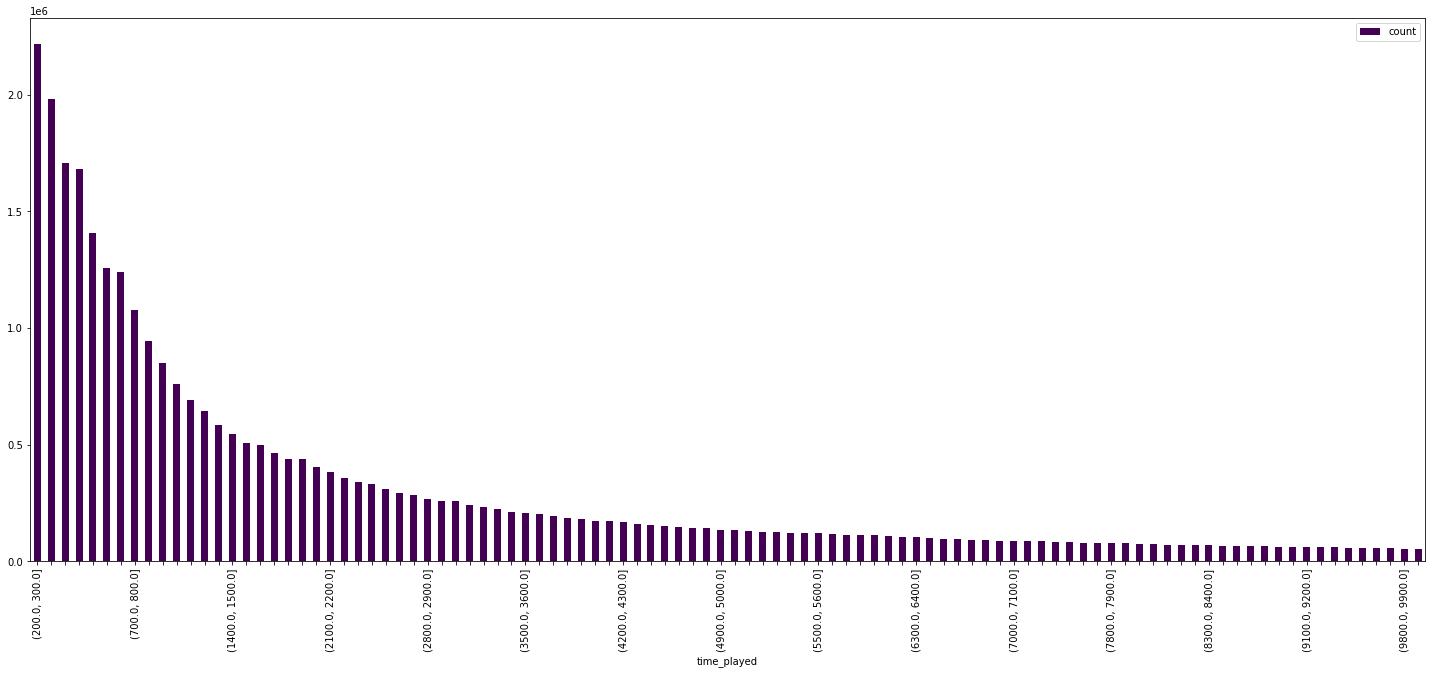

In [ ]:
# number of hours played before reviewing a game
dfs['time_played'] = pd.cut(dfs['author.playtime_at_review'], bins=np.arange(0,3228103.0, 100), include_lowest=True)  #3228103 is the maximum time played

hours_played = dfs.value_counts(["time_played"]).reset_index(name='count')

print(hours_played["count"].mean())

ax = hours_played[0:100].plot(x='time_played', y='count', kind = "bar", colormap = "viridis", figsize = (25,10))
plt.xticks(rotation=90)

temp = ax.xaxis.get_ticklabels()
temp = list(set(temp) - set(temp[::7]))
for label in temp:
    label.set_visible(False)
plt.show()


Most reviewers played less than 1500 hours, namely, less than two months before writing a review. More specifically, on average people played 1198 hours (which correspond to roughly 50 days) before reviewing the game, which seems to be quite a reasonable timeframe to test a game.

\\

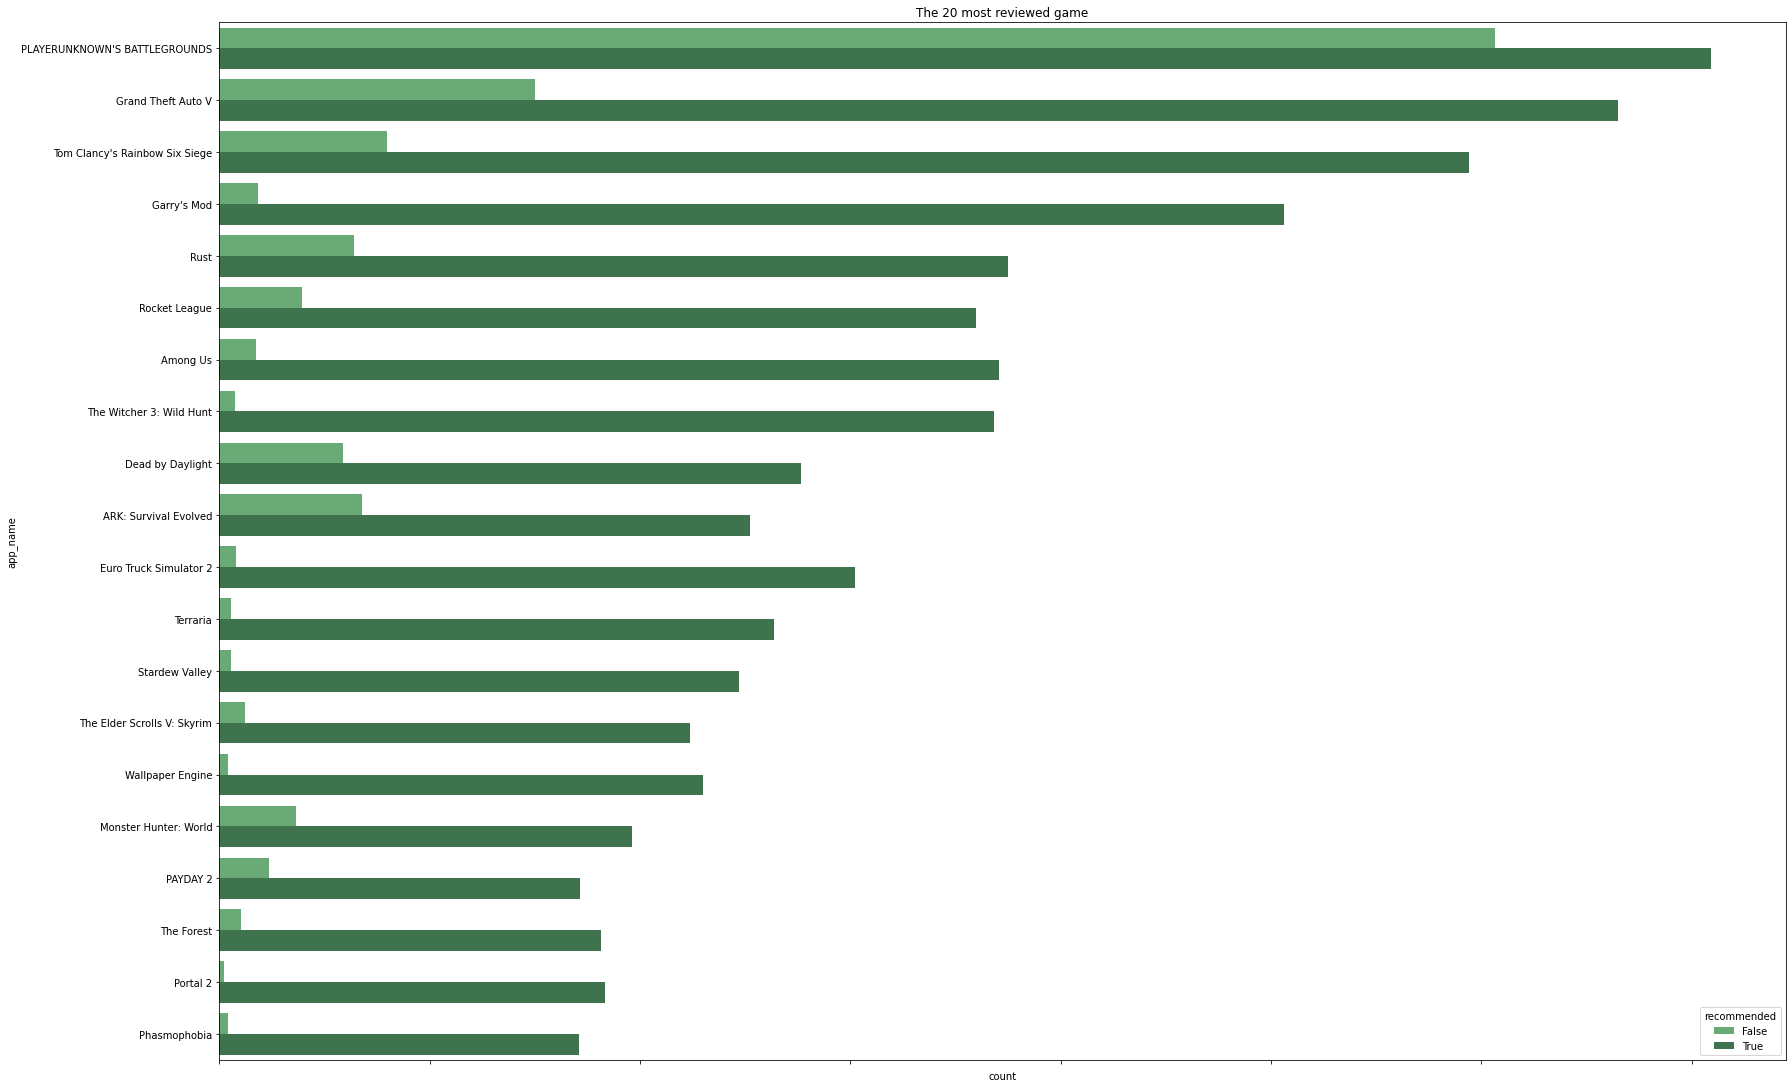

In [ ]:
plt.figure(figsize=(25,15))
ax = sns.countplot(y='app_name', data=dfs, hue='recommended', palette="Greens_d",
              order=dfs.app_name.value_counts().iloc[:20].index)

ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
plt.tight_layout()
plt.title("The 20 most reviewed game")
plt.show()

As the number of reviews increase, positive and negative reviews do not grow at the same rate. Still, it is interesting to notice that the most reviewed game (*PLAYERUNKNOWN'S BATTLEGROUNDS*) is both the most loved and the most disliked, which is probably caused by the game's tremendous popularity.

\\

# **[RQ2] -  Let's explore the dataset by finding simple insights into the reviews** 

**Plot the number of reviews for each application in descending order**


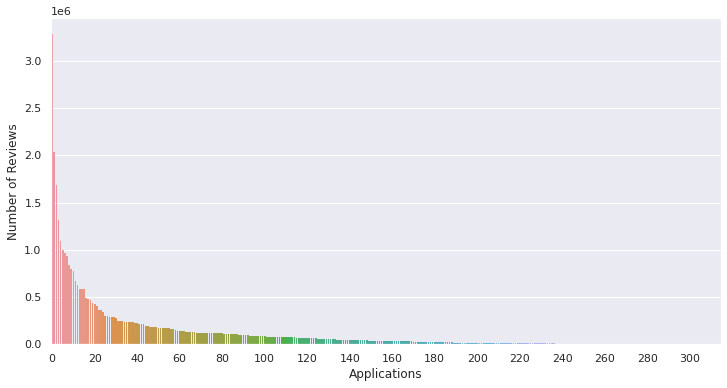

In [ ]:
reviews = dfs.groupby('app_id').review_id.count().sort_values(ascending=False)

plt.figure(figsize=(12,6))
sns.set()
sns.barplot(x=np.arange(len(reviews)), y=reviews, edgecolor='none')
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=20))
plt.xlabel('Applications')
plt.ylabel('Number of Reviews')
plt.show()


In [ ]:
print(reviews)
print("\n")
print(dfs.loc[dfs['app_id'] == 578080]["app_name"].head(1))
print("\n")
print(dfs.loc[dfs['app_id'] == 454200]["app_name"].head(1))

app_id
578080    3288510
271590    2038232
359550    1683836
4000      1311048
252490    1098148
           ...   
400940       1298
551730       1200
619290        700
574050        600
454200        400
Name: review_id, Length: 315, dtype: int64


13769326    PLAYERUNKNOWN'S BATTLEGROUNDS
Name: app_name, dtype: object


7245185    Neon Hardcorps
Name: app_name, dtype: object


The number of reviews by app is fairly variegated, ranging from **3,288,510 reviews** for the app with id 578080 (which corresponds - as predictable - to *PLAYERUNKNOWN'S BATTLEGROUNDS*) to **400 reviews** for the game *Neon Hardcorps*. From the print, we also see that the dataset contains reviews for a total of 315 apps.

**What applications have the best Weighted Vote Score?**

In [ ]:
#group by application and compute average
higher_wvs = dfs.groupby('app_name')['weighted_vote_score'].mean().reset_index(name='mean_wvs')


higher_wvs.sort_values(by = "mean_wvs" ,
                     ascending = False).head(5)

,app_name,mean_wvs
135,Hunt Down The Freeman,0.502150
292,Urban Empire,0.438623
150,METAL GEAR SURVIVE,0.421632
138,Identity,0.415384
290,Umbrella Corps,0.414678


The average weighted scores we compute are not very high, with the largest one reaching only 0.5. This may be due to the fact the the *weighted_vote_score* feature contains the scores given to the game by the single reviews. Therefore, the high votes assigned by some reviews get counterbalanced by reviews appointing medium and low scores, so that - on average - games do not achieve significantly high scores.

**Which applications have the most and the least recommendations?**

In [ ]:
# ones with most "recommended" (i.e., recommended = True)
numb_recommendations_by_app = dfs.groupby('app_name')['recommended'].sum().reset_index(name='count')

numb_recommendations_by_app.sort_values(by = "count" ,
                     ascending = False).head()

,app_name,count
182,PLAYERUNKNOWN'S BATTLEGROUNDS,1772834
118,Grand Theft Auto V,1662622
273,Tom Clancy's Rainbow Six Siege,1484793
114,Garry's Mod,1265116
208,Rust,937784


In [ ]:
# ones with least "recommended" (i.e., recommended = True)
numb_recommendations_by_app.sort_values(by = "count").head()

,app_name,count
164,Neon Hardcorps,178
59,DRAGON QUEST HEROES™ II,423
176,Out of the Park Baseball 19,594
292,Urban Empire,759
138,Identity,878


As we noted above, *PLAYERUNKNOWN'S BATTLEGROUNDS* and *Neon Hardcorps* are, respectively, the most and the least reviewed apps. In light of such finding, the results we just obtained make very much sense: since many reviews are written about *PLAYERUNKNOWN'S BATTLEGROUNDS*, this app also gets the most recommendations. Conversely, since *Neon Hardcorps* seems to be quite an uncommon game, there are less reviews that can accord recommendations. If we look at percentages, in fact, Neon Hardcorps doesn't do that bad, with around 48 percent of its reviews recommending the game.

**How many of these applications were purchased, and how many were given for free?**

In [ ]:
num_apps_purchased = dfs['steam_purchase'].sum()
num_apps_free = dfs['received_for_free'].sum()

print('Number of apps purchased = {}'.format(num_apps_purchased))
print('Number of apps given for free = {}'.format(num_apps_free))

Number of apps purchased = 30277068
Number of apps given for free = 1194096


# **[RQ3] Now it's important to understand the preferred time to do reviews**

**What is the most common time that authors review an application? For example, authors usually write a review at 17:44.**

In [ ]:
review_time_mode = dfs['timestamp_created'].dt.strftime('%H:%M').mode() # get requested time format (HH:MM)

print('Authors usually write a review at {}'.format(review_time_mode[0]))

Authors usually write a review at 14:50


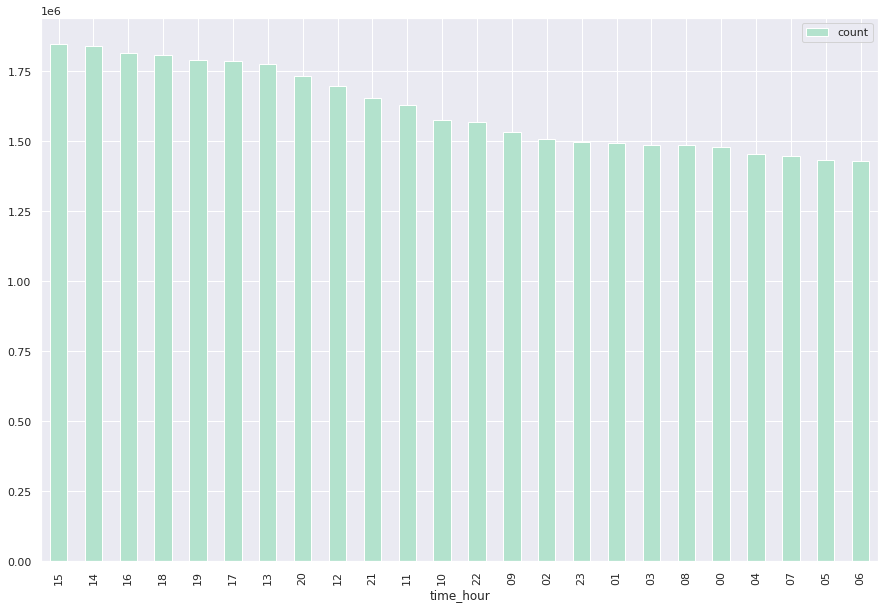

In [ ]:
dfs['time_hour'] = dfs['timestamp_created'].dt.strftime('%H') # only take hours

hours = dfs.value_counts(["time_hour"]).reset_index(name='count') # count number of reviews in each hour

hours.plot(x='time_hour', y='count', kind='bar', colormap = "Pastel2", figsize = (15,10))
plt.show()

We confirm graphically what we had already discovered with the **mode()** operator: the time of the day in which people write more reviews is at about **15** (3 PM).

\\

**Create a function that receives as a parameter a list of time intervals and returns the plot the number of reviews for each of the intervals.**

**Use the function that you created in the previous literal to plot the number of reviews between the following time intervals**

None


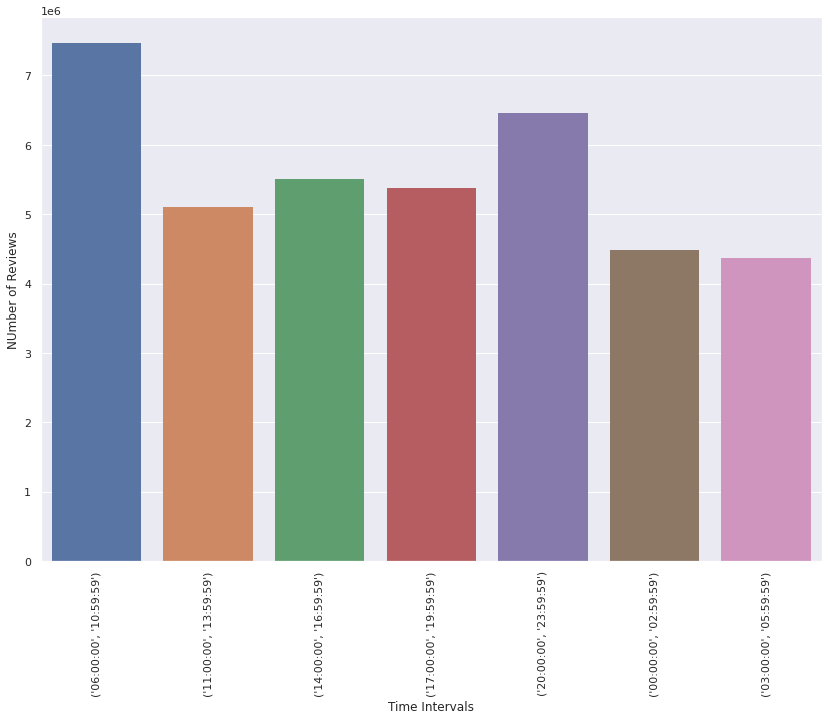

In [ ]:
times = [("06:00:00", "10:59:59"),
("11:00:00", "13:59:59"),
("14:00:00", "16:59:59"),
("17:00:00", "19:59:59"),
("20:00:00", "23:59:59"),
("00:00:00", "02:59:59"),
("03:00:00", "05:59:59")]

print(f.reviews_interval(times))

It is a bit peculiar that the highest number of reviews is written early in the morning, between 6 AM and 11 AM, as such a time period does not typically correspond to the moment of the day in which people usually play video games. \\

One possible explanation may be that the time registered by the Steam platform does not depend on the country where the review is written. 

For example, we see that when in New York (**USA**) it's *9 AM*, in Beijing (**China**) it's *9PM* and in Vladivostok (**Russia**) *11 PM*. Therefore, a review written by a gamer living in one of the latter two cities may end up in the *("06:00:00", "10:59:59")* time class, when it was actually posted in the evening.


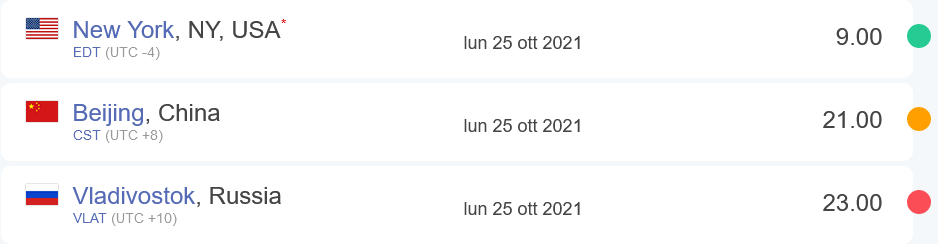

**Image generated using the 
 [Time Zone Converter – Time Difference Calculator](https://https://www.timeanddate.com/worldclock/converter.html) website**

\\

# **[RQ4] As Steam is a worldwide platform, the reviews can be done in many languages. Let's extract some information about it.**
**What are the top 3 languages used to review applications?**

In [ ]:
common_langs_list = dfs.value_counts(["language"]).reset_index(name='count').loc[0:2]['language'].tolist()
print(common_langs_list)

['english', 'schinese', 'russian']


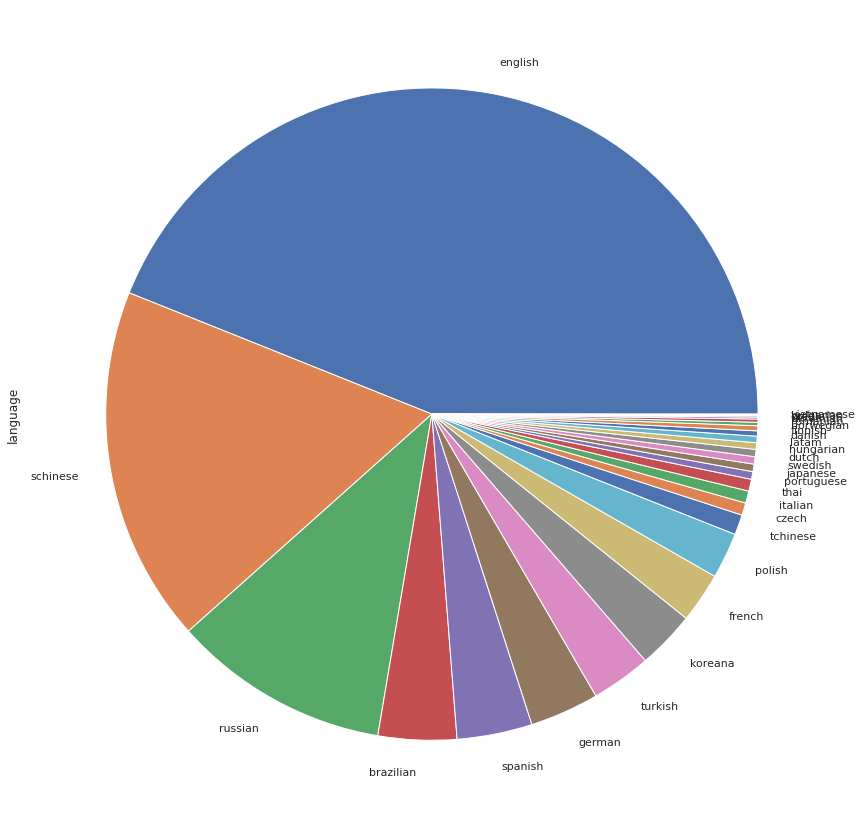

In [ ]:
dfs.language.value_counts().plot(kind='pie', figsize=(15,15))

The **pie chart** visually confirms that English is the most popular language in the Steam dataset, followed by Simplified Chinese and Russian.

\\

**Create a function that receives as parameters both the name of a data set and a list of languages’ names and returns a data frame filtered only with the reviews written in the provided languages.**

**Use the function created in the previous literal to find what percentage of these reviews (associated with the top 3 languages) were voted as funny?**

In [ ]:
df_langs = lang_function('dfs',common_langs_list)

numb_funny_top_langs = len(df_langs[(df_langs['votes_funny'] > 0)]) # number of rows where votes_funny is larger than zero

percentage = numb_funny_top_langs / len(df_langs) * 100
print("The number of funny votes in the reviews written in either English, Simplified Chinese or Russian is", numb_funny_top_langs, "which corresponds to the", percentage, "%")

The number of funny votes in the reviews written in either English, Simplified Chinese or Russian is 3309692 which corresponds to the 11.806883904057251 %


**Use the function created in the literal “a” to find what percentage of these reviews (associated with the top 3 languages) were voted as helpful?**

In [ ]:
numb_helpful_top_langs = len(df_langs[(df_langs['votes_helpful'] > 0)]) # number of rows where votes_helpful is larger than zero

percentage = numb_helpful_top_langs / len(df_langs) * 100
print("The number of helpful votes in the reviews written in either English, Simplified Chinese or Russian is", numb_helpful_top_langs, "which corresponds to the", percentage, "%")

The number of helpful votes in the reviews written in either English, Simplified Chinese or Russian is 7884753 which corresponds to the 28.127802612196884 %


# **[RQ5] The reviews' authors are users from the game that provide their opinion on it. Now you can check how often they make reviews**

**Plot the top 10 most popular reviewers and the number of reviews.**

Defining "popularity" is not easy, as, being a subjective concept, there are no scientific rules we can all agree upon to characterize it. \\

Here, we have decided to consider as a proxy for popularity the number of reviews in which the writer received at least one helpful vote, as we believe that popularity is a quality that gets determined by the opinion of others . Of course, this is only one option among several, like, for example, counting the total number of helpful votes received by a reviewer across all the reviews he or she wrote. 

In [ ]:
numb_helpful_votes_by_player = dfs[dfs['votes_helpful'] >0].groupby(['author.steamid']).size().reset_index(name='count').sort_values(by = "count" ,
               ascending = False).head(10)  # for each player, count rows where votes helpful have been received

numb_helpful_votes_by_player['author.steamid'] = numb_helpful_votes_by_player['author.steamid'].astype(np.int)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

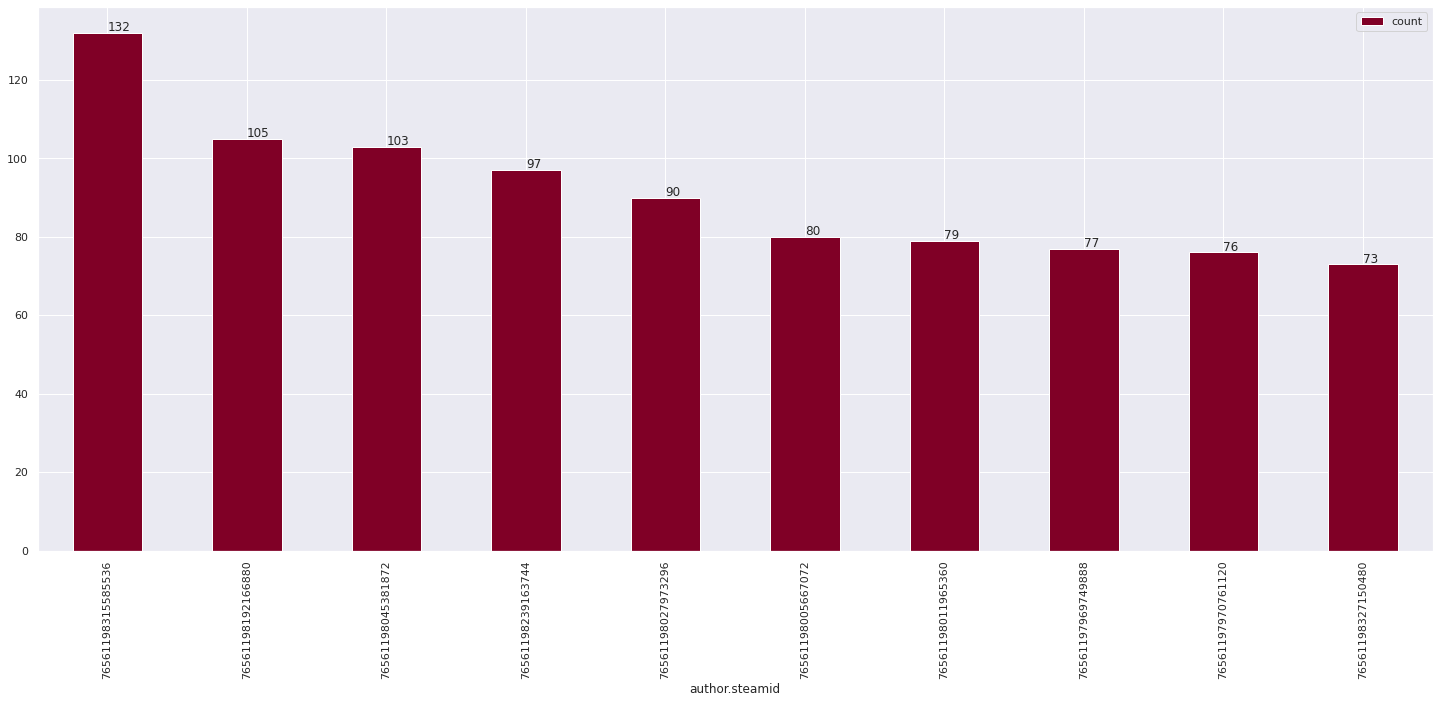

In [ ]:
# plot the most 10 most popular reviewers

ax = numb_helpful_votes_by_player[0:10].plot(x='author.steamid', y='count', kind = "bar", colormap = "YlOrRd_r", figsize = (25,10))

xlocs, xlabs = plt.xticks()

for i, v in enumerate(numb_helpful_votes_by_player[0:10]["count"]): # add values over bar
    plt.text(xlocs[i], v + 0.5, str(v))

plt.xticks(rotation=90)

We consider as the most popular reviewer the one with id 76561198315585536, who wrote **132 reviews** that received helpful votes.

\\

**What applications did the most popular author review?**

In [ ]:
top_author = numb_helpful_votes_by_player.iloc[0,0]

# dataframe consisting of only the top author
df_top_author = dfs.loc[dfs['author.steamid'] == top_author]

pd.set_option('display.max_rows', None)
top_author_apps = df_top_author['app_name'].unique()
print(top_author_apps)

['The Witcher 3: Wild Hunt' "Garry's Mod" "Sid Meier's Civilization V"
 'Dead by Daylight' "Sid Meier's Civilization VI" 'Subnautica'
 'Human: Fall Flat' 'Celeste' 'A Hat in Time' 'Overcooked! 2' 'The Forest'
 'Deus Ex: The Fall' 'Rapture Rejects' 'Umbrella Corps'
 'The Binding of Isaac: Rebirth' 'Titan Souls'
 'Shovel Knight: Treasure Trove' 'Super Meat Boy' 'Enter the Gungeon'
 'Hollow Knight' 'The End Is Nigh' 'RimWorld' 'Insurgency: Sandstorm'
 'Slay the Spire' 'Euro Truck Simulator 2' 'Wallpaper Engine'
 'Pathfinder: Kingmaker' 'Into the Breach' 'Warhammer: Vermintide 2'
 'Borderlands 3' 'Sekiro™: Shadows Die Twice' 'Total War: THREE KINGDOMS'
 'DOOM Eternal' 'A Short Hike' 'Void Bastards'
 "Tom Clancy's Rainbow Six Siege" 'DRAGON BALL FighterZ' 'HITMAN™ 2'
 "Assassin's Creed Odyssey" 'Mount & Blade: Warband' 'Resident Evil 2'
 'Slime Rancher' 'Hotline Miami' 'Tomb Raider' 'BattleBlock Theater'
 'Dishonored' 'South Park™: The Stick of Truth™' "Don't Starve"
 'Rocket League' 'Perso

Other than the names of the games reviewed by the most popular reviewer, we also notice that he or she wrote exactly **132 reviews**, which implies that for each feedback they gave, at least one person found it helpful.

\\

**How many applications did he purchase, and how many did he get as free? Provide the number (count) and the percentage.**

In [ ]:
all = df_top_author['app_id'].count() # all apps the top author reviewed
purchased = df_top_author['steam_purchase'].sum() # apps the top author purchased
purchased_percent = (purchased/all)*100 # percentage of purchased apps 

df_top_author = dfs.loc[dfs['author.steamid'] == top_author]

free = df_top_author['received_for_free'].sum() # apps the top author got for free
free_percent = (free/all)*100 # percentage of free apps 

unspecified_percent = ((all - purchased - free)/all) * 100 # apps unspecified whether purchased or received for free

print('Applications the top author purchased:\nCount = {}    percentage = {:.2f}%'.format(purchased, purchased_percent))
print()
print('Applications the top author received for free:\nCount = {}    percentage = {:.2f}%'.format(free, free_percent))
print()
print('Applications unspecified whether free or purchased:\npercentage = {:.2f}%'.format(unspecified_percent))

Applications the top author purchased:
Count = 91    percentage = 68.94%

Applications the top author received for free:
Count = 1    percentage = 0.76%

Applications unspecified whether free or purchased:
percentage = 30.30%


# **[RQ6] It's time to get information from the updates that a user does to his reviews.**

**What is the average time (days and minutes) a user lets pass before he updates a review?**

In [ ]:
dfs['update_interval'] = dfs['timestamp_updated'] - dfs['timestamp_created']

avg_update = dfs['update_interval'].mean()
avg_update = pd.Timedelta.round(avg_update,'60s')

print("On average, people wait", avg_update, "before updating their review")

On average, people wait 27 days 18:26:00 before updating their review


\\

**Plot the top 3 authors that usually update their reviews**

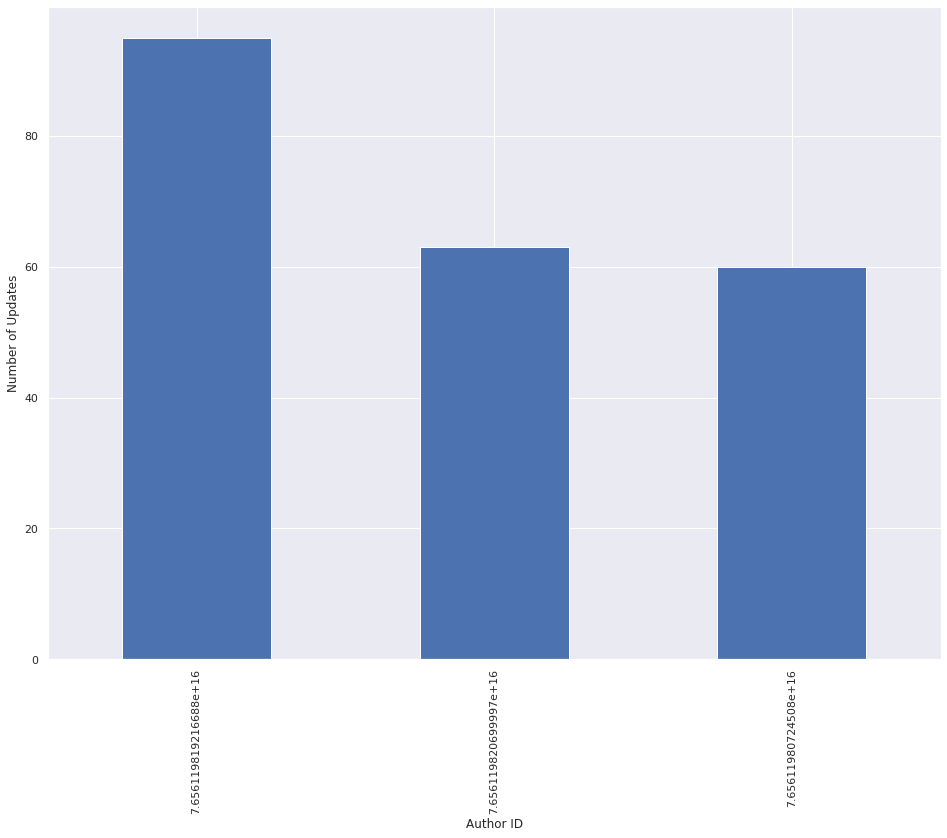

In [ ]:
authors_updating = dfs.loc[dfs['update_interval'] != timedelta(days = 0, minutes = 0, seconds = 0), 'author.steamid'].value_counts().head(3)

authors_updating.plot.bar(figsize = (16,12))
plt.xticks(rotation=90)
plt.xlabel('Author ID')
plt.ylabel('Number of Updates')

plt.show()

# **[RQ7] Of course, calculating probabilities is a job that any Data Scientist must know. Let's compute Some interesting figures.**

**What’s the probability that a review has a Weighted Vote Score equal to or bigger than 0.5?**

In [ ]:
large_vote_score = len(dfs.loc[dfs["weighted_vote_score"] >= 0.5])
high_score = dfs.loc[dfs["weighted_vote_score"] >= 0.5] 

prob_vote_score_05 = large_vote_score / len(dfs) 

print("The probability that a review has a Weighted Vote Score equal to or bigger than 0.5 is: ", prob_vote_score_05) # p(wvs > 0.5)

The probability that a review has a Weighted Vote Score equal to or bigger than 0.5 is:  0.21751901567721846


**What’s the probability that a review has at least one vote as funny given that the Weighted Vote Score is bigger than 0.5?**

In [ ]:
high_score_and_funny = high_score.loc[dfs["votes_funny"] > 0] # number of lines where a review has at least one vote as funny and a Weighted Vote Score bigger than 0.5

perc_high_score_and_funny = len(high_score_and_funny) / len(high_score) # p(at_least_one_funny | wvs > 0.5) = p(at_least_one_funny, wvs > 0.5)/p(wvs > 0.5)
print("The probability that a review has at least one vote as funny given that the Weighted Vote Score is bigger than 0.5 is: ", perc_high_score_and_funny)


The probability that a review has at least one vote as funny given that the Weighted Vote Score is bigger than 0.5 is:  0.19035557627941135


**Is the probability that “a review has at least one vote as funny” independent of the “probability that a review has a Weighted Vote Score equal or bigger than 0.5”?**


In [ ]:
at_least_one_funny = len(dfs.loc[dfs["votes_funny"] > 0]) / len(dfs) # p(at_least_one_funny)


indep = at_least_one_funny * prob_vote_score_05 # p(at_least_one_funny, wvs > 0.5) = p(at_least_one_funny) * p(wvs > 0.5). Here, p(wvs > 0.5, at_least_one_funny) = p(wvs > 0.5) * p(at_least_one_funny)

print("The probability that a review has at least one vote as funny is: ", at_least_one_funny)  # p(at_least_one_funny | wvs > 0.5) = 0.24 differs from p(at_least_one_funny) = 0.11

print("The probability that a review has at least one vote as funny and a Weighted Vote Score equal or bigger than 0.5 is: ", len(high_score_and_funny) / len(dfs)) # p(at_least_one_funny , wvs > 0.5)
print("The probability that a review has at least one vote as funny times the probability that a review has a Weighted Vote Score equal or bigger than 0.5 is: ", indep) # marginals p(at_least_one_funny, wvs > 0.5) = 0.054 differs from p(at_least_one_funny) * p(wvs > 0.5) = 0.026  --> not independent


The probability that a review has at least one vote as funny is:  0.11675112099863498
The probability that a review has at least one vote as funny and a Weighted Vote Score equal or bigger than 0.5 is:  0.04140595758096723
The probability that a review has at least one vote as funny times the probability that a review has a Weighted Vote Score equal or bigger than 0.5 is:  0.02539558891883491


**More concisely:**

Conditional probability between events can be calculated as:

$$\color{blue}{P(\mathrm{at \ least \ one \ vote \ funny} \ | \ \mathrm{Weighted \ Vote \ Score >= \ 0.5} ) = \frac{P( at \ least \ one \ vote \ funny \cap Weighted \ Vote \ Score >= \ 0.5)}{P(Weighted \ Vote \ Score >= \ 0.5)}}$$

If the events are independent, we have:

$$\color{blue}{P(\mathrm{at \ least \ one \ vote \ funny} \ | \ \mathrm{Weighted \ Vote \ Score >= \ 0.5} ) = {P( at \ least \ one \ vote \ funny)}}$$

\\

But we have:
$$\color{green}{P(\mathrm{at \ least \ one \ vote \ funny} \ | \ \mathrm{Weighted \ Vote \ Score >= \ 0.5} ) = 0.19 }$$

which is clearly different from: 

$$\color{green}{P(\mathrm{at \ least \ one \ vote \ funny}) = 0.11 }$$

\\

\\
Moreover, we also checked that:

$$\color{orange}{\mathrm{P( at \ least \ one \ vote \ funny \cap Weighted \ Vote \ Score >= \ 0.5)} = 0.041}$$

is different from:
$$\color{orange}{\mathrm{P( at \ least \ one \ vote \ funny) * P (Weighted \ Vote \ Score >= \ 0.5)} = 0.025}$$

\\

\\


We conclude that the two events, $$\color{red}{\mathrm{P( at \ least \ one \ vote \ funny)}}$$ and $$\color{red}{\mathrm{P (Weighted \ Vote \ Score >= \ 0.5)}}$$ 

\

$$\color{red}{are  \ not \ independent}$$

\\


# **[RQ8] Every decision you take in a data-based environment should be reinforced with charts, statistical tests and analysis methods to check if a hypothesis is correct or not.**

**Is there a significant difference in the Weighted Vote Score of reviews made in Chinese vs the ones made in Russian? Use an appropriate statistical test or technique and support your choice.**

The following part of the report shows that there is a difference between the two groups of reviews. 

In order to test it, we tried to get a look at the distribution of the weighted scores, dividing the dataset in the two subsets. As we can see, the distribution of the value is a mixture of a *Normal distribution* and a *Degenerete in zero*. 
One possible idea to detect if there is a significative difference between the two groups of reviews written in different languages is to use the **t-test**, but essentially we can't use it with a non-normal distribution and, also avoiding the zero values, the **Shapiro** normality test refuses the null hypothesis H0 "the data are distribuited like a gaussian distribution".
So, what we have done in pratice, is applying a few **non-parametrical tests**.

Teoretically speaking, it could be better to estimate a zero inflated model, in order to detect the impact of the Language variable on the weighted score.

In [ ]:
s1=dfs['weighted_vote_score'][dfs['language'] == 'russian']
s2=dfs['weighted_vote_score'][dfs['language'] == 'schinese']
z1= s1[s1!=0]
z2= s2[s2!=0]

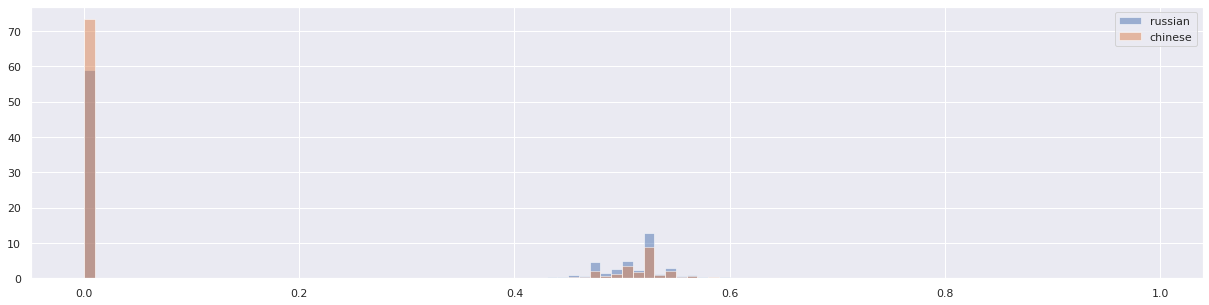

In [ ]:
bin_values=np.arange(start=0, stop=1, step=0.01)
s1.hist(bins=bin_values, figsize=[21,5],alpha=0.5,label="russian",density=True)
s2.hist(bins=bin_values, figsize=[21,5],alpha=0.5,label="chinese",density=True)
plt.legend(loc='upper right')
plt.show()

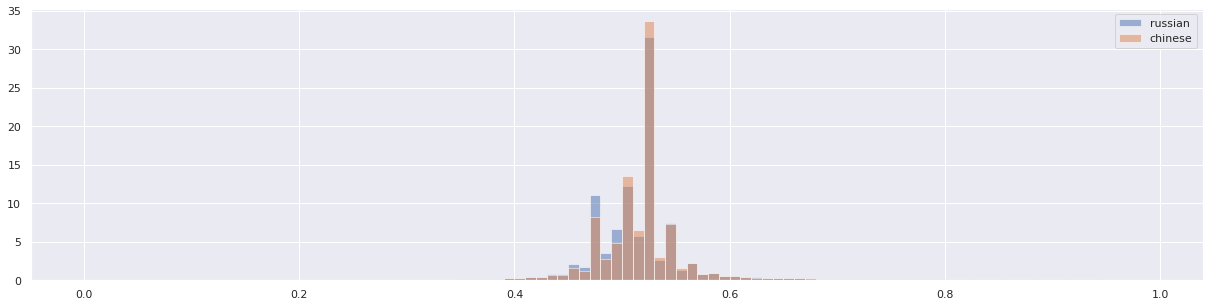

In [ ]:
bin_values=np.arange(start=0, stop=1, step=0.01)
z1.hist(bins=bin_values, figsize=[21,5],alpha=0.5,label="russian",density=True)
z2.hist(bins=bin_values, figsize=[21,5],alpha=0.5,label="chinese",density=True)
plt.legend(loc='upper right')
plt.show()

After the elimination of the zeros in the distribution, it is clear how the distributions are similar, but we should test it.
In order to use a **t-test** to detect the difference between these, we might first test the normality.

In [ ]:
print(stats.shapiro(z1))
print(stats.shapiro(z1))

(0.756714940071106, 0.0)
(0.756714940071106, 0.0)


/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Since the **Shapiro–Wilk test** reveals a non-normal shape of the distribution, we will use a **non-parametric test**.

In [ ]:
from scipy.stats import mannwhitneyu
from scipy.stats import kruskal
print(mannwhitneyu(s1, s2))
print(kruskal(s1, s2))
print(mannwhitneyu(z1, z2))
print(kruskal(z1, z2))

MannwhitneyuResult(statistic=12346699964312.0, pvalue=0.0)
KruskalResult(statistic=nan, pvalue=nan)
MannwhitneyuResult(statistic=1439010472754.5, pvalue=0.0)
KruskalResult(statistic=nan, pvalue=nan)


In the two parametrical tests, **Mann-Whitney U** and **Kruskal**, the **low values of the p-values** suggest that there is a difference between distributions.

**Can you find any significant relationship between the time that a user lets pass before he updates the review and the Weighted Vote Score? Use an appropriate statistical test or technique and support your choice.**

A way to find if there is any significant relationship between the time that a user lets pass before he updates the review and the Weighted Vote Score is through a **Linear Model** and the relative scatterplot.
Of course, since we are talking about updated reviews we should avoid all the rows that have not received an update.

In [ ]:
dfs['delta_time_s']=dfs['update_interval'].apply(lambda x: x.total_seconds())

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.003
Model:                            OLS   Adj. R-squared (uncentered):              0.003
Method:                 Least Squares   F-statistic:                          1.746e+04
Date:                Sun, 31 Oct 2021   Prob (F-statistic):                        0.00
Time:                        10:56:15   Log-Likelihood:                     -8.2901e+06
No. Observations:             5848600   AIC:                                  1.658e+07
Df Residuals:                 5848599   BIC:                                  1.658e+07
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

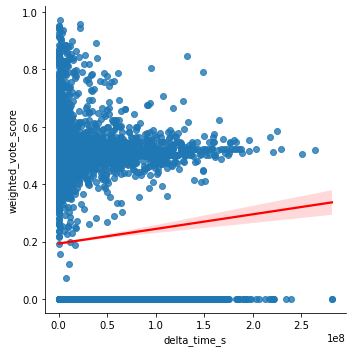

In [ ]:
X=dfs.loc[dfs['delta_time_s']!=0, 'delta_time_s']
Y= dfs.loc[dfs['delta_time_s']!=0, 'weighted_vote_score']
Y = Y[Y.notna()]
X = X[X.notna()]
from sklearn import preprocessing
import statsmodels.api as sm # import statsmodels 
X=preprocessing.scale(X)
Y=preprocessing.scale(Y)
model = sm.OLS(Y, X).fit()
predictions = model.predict(X)
print(model.summary())
df=dfs.sample(100000)
df=df[df['delta_time_s']!=0]
sns.lmplot(x="delta_time_s", y='weighted_vote_score', data=df,line_kws={'color': 'red'})

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.000
Model:                            OLS   Adj. R-squared (uncentered):              0.000
Method:                 Least Squares   F-statistic:                              105.6
Date:                Sun, 31 Oct 2021   Prob (F-statistic):                    9.11e-25
Time:                        10:55:46   Log-Likelihood:                     -3.2398e+06
No. Observations:             2283321   AIC:                                  6.480e+06
Df Residuals:                 2283320   BIC:                                  6.480e+06
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

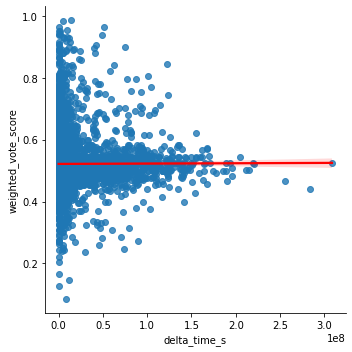

In [ ]:
X=dfs.loc[(dfs['delta_time_s']!=0) & (dfs['weighted_vote_score']!=0), 'delta_time_s']
Y= dfs.loc[(dfs['delta_time_s']!=0) & (dfs['weighted_vote_score']!=0), 'weighted_vote_score']
Y = Y[Y.notna()]
X = X[X.notna()]
from sklearn import preprocessing
import statsmodels.api as sm # import statsmodels 
X=preprocessing.scale(X)
Y=preprocessing.scale(Y)
model = sm.OLS(Y, X).fit()
predictions = model.predict(X)
print(model.summary())
df=dfs.sample(100000)
df=df[df['delta_time_s']!=0]
df=df[df['weighted_vote_score']!=0]
sns.lmplot(x="delta_time_s", y='weighted_vote_score', data=df, line_kws={'color': 'red'})

As we can see in these two plots and from the results of the relative models, **there isn't a relationship** between the two distributions.
In the first case we consider inside the data all the reviews with a score equal to zero, and in the second one only the rows with a value of score greater than zero, but in any case the coefficient is significative, so it is reliable, but it attests the non correlation.

**Is there any change in the relationship of the variables mentioned in the previous literal if you include whether an application is recommended or not in the review? Use an appropriate statistical test or technique and support your choice.**

In this case, to test if there is a difference dividing and analyzing the relationship considering if a review is or not recommended, we are going to estimate a model with interaction between predictors.

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


Intercept       0.3420158600617388
Coefficient Recommended   -0.0348216738351096
Coefficient Updates   -0.40684101807357426
Coefficient Interaction   0.10470877031257259


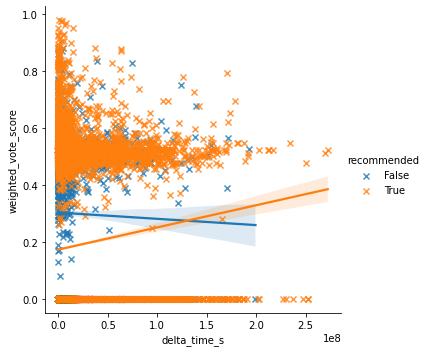

In [ ]:
#model with 2 predictors
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
X1=dfs.loc[dfs['delta_time_s']!=0, 'delta_time_s']
X2=dfs.loc[dfs['delta_time_s']!=0, 'recommended']
Y= dfs.loc[dfs['delta_time_s']!=0, 'weighted_vote_score']
X2=1*X2
X2 = X2.astype(np.float)
X1=preprocessing.scale(X1)
X3=X1*X2
X=pd.DataFrame({"x1":X1,"x2":X2,"x3":X3})
X = X[X["x1"].notna()]
Y = Y[Y.notna()]
Y=preprocessing.scale(Y)
reg = LinearRegression().fit(X, Y) 

print('Intercept      ',reg.intercept_)
print('Coefficient Recommended  ',reg.coef_[0])
print('Coefficient Updates  ',reg.coef_[1])
print('Coefficient Interaction  ',reg.coef_[2])
df=dfs.sample(100000)
df=df[df['delta_time_s']!=0]
sns.lmplot(x="delta_time_s", y='weighted_vote_score', hue='recommended',markers="x", data=df)


Using the splitting of the data in two sets of recommended and not, as we can see just above, the recommended reviews receive, on average, the same score totally indipendently of the time of the update, instead the not recommended, if updated after a lot of time, on average, obtain a low value of weighted score.

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


Intercept       0.3420158600617388
Coefficient Recommended   -0.0348216738351096
Coefficient Updates   -0.40684101807357426
Coefficient Interaction   0.10470877031257259


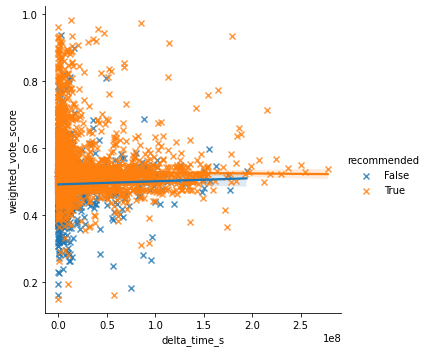

In [ ]:
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
X1=dfs.loc[dfs['delta_time_s']!=0, 'delta_time_s']
X2=dfs.loc[dfs['delta_time_s']!=0, 'recommended']
Y= dfs.loc[dfs['delta_time_s']!=0, 'weighted_vote_score']
X2=1*X2
X2 = X2.astype(np.float)
X1=preprocessing.scale(X1)
X3=X1*X2
X=pd.DataFrame({"x1":X1,"x2":X2,"x3":X3})
X = X[X["x1"].notna()]
Y = Y[Y.notna()]
Y=preprocessing.scale(Y)
reg = LinearRegression().fit(X, Y) 

print('Intercept      ',reg.intercept_)
print('Coefficient Recommended  ',reg.coef_[0])
print('Coefficient Updates  ',reg.coef_[1])
print('Coefficient Interaction  ',reg.coef_[2])
df=dfs.sample(100000)
df=df[df['delta_time_s']!=0]
df=df[df['weighted_vote_score']!=0]
sns.lmplot(x="delta_time_s", y='weighted_vote_score', hue='recommended',markers="x", data=df)


In this second case, so avoiding the values of score equato to zero, it is absolutly clear how there isn't,
not even splitting with recommended the dataframe, a correlation between these two continuos variables.

**What are histograms, bar plots, scatterplots and pie charts used for?**


Histograms are a type of plot useful to describe the distribution of a continuous variable, and so they allow us to evaluate the shape and some summaries.
They should be divided into bins in order to group the values close.


Barplots are used to show the frequencies, relative or absolute, of the modalities of a categorical (or qualitative) variable.

Scatterplots are the best way to compare two continuous variables to detect if there is a correlation, or maybe a non linear relation between them.
Each single observation is represented by a point in a Cartesian plane exactly in the position of the values ​​that it assumes on the two variables.

If we are interested in a partition of our observations, and we would like to see what are the percentages of each modality, the better way to do it is - of course - a pie plot.
Extremely communicative and intuitive.

**What insights can you extract from a Box Plot?**

Boxplots are plots really useful to show some features of distribution, like median (second quartile), first quartile, and third quartile.
In this way, the plot shows us also the range interquartile and the range of value that the variable assumes.
Sometimes with some points in this plot, we identify the outliers.

# **Theoretical Question 1**




**What does the algorithm compute?**

In [31]:
import random

def alg(A, k):
    s = random.choice(A)
    L = list(set([t for t in A if t <= s]))
    R = list(set([t for t in A if t > s]))
    r = len(L)
    if k == r:
        return s
    elif k < r:
        return alg(L, k)
    else:
        return alg(R, k - r)
print(alg([9,8,7,6,2],3))

7


This algorithm returns the k-th smallest value of the array in input, reciving like parameters of the function the array A and the position K. Obviusly k might assume values between 1 and n, where n in the lenght of the array.

**What is asymptotically (i.e., we are asking for big-O complexity) the running time of the algorithm in the worst case, as a function of n?**


In the worst case the lenght of the array we are evaluating decrease of one unit per times.
So we execute the algorithm on a list of n elements, then n-1 element, then n-2...

Infact the running time for this case will be: 
$ T(n)=2n+2 + 2(n-1)+2 +...+ 2(1)+2= 2(n(n-1)/2)+2n= 2n^2+an +b$

So Big-O complexity is:
$ O(n)=n^2 $

**What is asymptotically the running time of the algorithm in the best case?**

Instead in the best case the first s is the value that I'm looking for, so the recursion of the algorithm has only one step, and is executed in:
$T(n)=2n+b$

So the asymptotical running time of the algorithm in the best case is equal to:

$ \Omega(n) $

# **Theoretical Question 2**

In [32]:
def splitSwap( a, l, n ):
    if n <= 1:
        return
    splitSwap(a, l, n//2)
    splitSwap(a, l+ n//2, n//2)
    swapList(a, l, n)
    
def swapList(a, l, n):
    for i in range(0,n//2):
        tmp = a[l + i]
        a[l + i] = a[l + n//2 + i]
        a[l + n//2 + i] = tmp

As delineated in the homework's text, the **splitSwap(a, l, n)** function takes as input an array *a*, an index *l* (which, as requested, we set to 0) and a  length *n*. It, then, runs through some recursive steps and calls the function **swapList(a, l, n)** to return a modified order (if n is a power of 2, then the order is reversed) of the first *n* digits (*n-1* if n is odd) of the array *a*, followed by the rest of the array (which is left untouched).

\\

\\
See the following chunk of code for an example:

In [33]:
a = [1, 10, 3, 4, 5]

splitSwap(a, 0, 2) # 1, 10 --> 10, 1
print(a)

a = [20, 18, 16, 14] # 20, 18, 16, 14 --> 14, 16, 18, 20 

splitSwap(a, 0, 4)
print(a)

a = [3, 4, 4, 3, 5, 20, 18, 16, 14] # 3, 4, 4, 3, 5, 20, 18, 16 --> 16, 18, 20, 5, 3, 4, 4, 3
splitSwap(a, 0, 8) # n is a power of 2
print(a)

a = [3, 4, 4, 3, 5, 20, 18, 16, 14] # 3, 4, 4, 3, 5, 20 --> 5, 3, 20, 4, 3, 4
splitSwap(a, 0, 6) # n is not a power of 2 (see mechanism below)
print(a)


[10, 1, 3, 4, 5]
[14, 16, 18, 20]
[16, 18, 20, 5, 3, 4, 4, 3, 14]
[5, 3, 20, 4, 3, 4, 18, 16, 14]


**If l = 0 and n is a power of 2**, we can divide the algorithmic process into four main steps:

1. for *n* larger than 1, split the array *a* into two "sub-arrays", the first one of which contains the first *n* digits and the second the remaining ones (i.e., len(*a*) - *n* digits);

2. recursively split each of the two sub-arrays, so that one array includes  the first *n*/2 components and the second gets the rest. The procedure is repeated until the base line is reached, namely, until only one number is left in the array;

3. go back to the previous splittings (that is, to arrays with two elements) and enter the for loop of the **swapList()** function to swap the elements from left to right. Repeat;

4. finally, retract to the first splitting and merge the two original halves.


**EXAMPLE with n = power of 2** :
\
Start with a = [20, 18, 16, 14], l = 0 and n = 4.
1. SplitSwap(a, 0, 4) [line 4] --> consider array [20, 18, 16, 14];
2. SplitSwap(a, 0, 2) [line 4] --> consider array [20, 18];
3. SplitSwap(a, 0, 1) [line 4] --> consider array [20]; \\
   Since n = 1: return
4. SplitSwap(a, 1, 1) [line 5] --> consider array [18]; \\
   Since n = 1: return
5. SwapList (a, 0, 2) --> Since n//2 = 1, the loop is executed once: \\
swipe 20 and 18 in the original array (i.e., a[0]=18 and a[1] = 20) \\
a becomes [18, 20, 16, 14];
6. SplitSwap(a, 2, 2) [line 5] --> consider array [16, 14];
7. SplitSwap(a, 2, 1) [line 4] --> consider array [16]; \\
 Since n = 1: return
8. SplitSwap(a, 3, 1) [line 5] --> consider array [14]; \\
 Since n = 1: return
9. SwapList (a, 2, 2) --> Since n//2 = 1, the loop is executed once: \\
swipe 16 and 14 in the original array (i.e., a[2]=14 and a[3] = 16) \\
a becomes [18, 20, 14, 16];
10. SwapList (a, 0, 4) --> Since n//2 = 2, the loop is executed twice: \\
swipe 18 and 14 in the original array (i.e., a[0]=14 and a[2] = 18) \\
a becomes [14, 20, 18, 16];
swipe 20 and 16 in the original array (i.e., a[1]=16 and a[3] = 20) \\
a becomes **[14, 16, 18, 20]**. The order has been reversed.

**EXAMPLE with n different from a power of 2** (just out of curiosity) :
\
Start with a = [3, 4, 4, 3, 5, 20, 18, 16, 14], *l* = 0 and *n* = 6.

1. SplitSwap(a, 0, 6) [line 4] --> consider array [3, 4, 4, 3, 5, 20];
2. SplitSwap(a, 0, 3) [line 4] --> consider array [3, 4, 4];
3. SplitSwap(a, 0, 1) [line 4] --> consider array [3]; \\
   Since n = 1: return
4. SplitSwap(a, 1, 1) [line 5] --> consider array [4]; \\
   Since n = 1: return
5. SwapList (a, 0, 3) --> Since n//2 = 1, the loop is executed once: \\
swipe 4 and 3 in the original array (i.e., a[0]=4 and a[1] = 3) \\
a becomes [4, 3, 4, 3, 5, 20];
6. SplitSwap(a, 3, 3) [line 5] --> consider array [3, 5, 2, 0];
7. SplitSwap(a, 3, 1) [line 4] --> consider array [3]; \\
 Since n = 1: return
8. SplitSwap(a, 4, 1) [line 5] --> consider array [5];\\
 Since n = 1: return
9. SwapList (a, 3, 3) --> Since n//2 = 1, the loop is executed once: \\
swipe 3 and 5 in the original array (i.e., a[3]=5 and a[4] = 3) \\
a becomes [4, 3, 4, 5, 3, 20];
10. SwapList (a, 0, 6) --> Since n//2 = 3, the loop is executed three times: \\
swipe 4 and 5 in the original array (i.e., a[0]=5 and a[3] = 4) \\
a becomes [5, 3, 4, 4, 3, 20];
swipe 3 and 3 in the original array (i.e., a[1]=3 and a[4] = 3) \\
a becomes [5, 3, 4, 4, 3, 20];
swipe 20 and 4 in the original array (i.e., a[2]=20 and a[5] = 4) \\
a becomes [5, 3, 20, 4, 3, 4].
11. Join a with the last original digits. Obtain **[5, 3, 20, 4, 3, 4, 18, 16, 14]**. The order is modified, but not reversed.

Note: For n odd it's the same procedure but each time the first sub-array contains the first n-1 digits. Also, we see that if *l* is set to an integer different from zero, the algorithm is applied to *n* digits starting from *l*-th element of the array.  




In [34]:
a = [1, 2, 3, 4, 5, 20, 18, 16, 14] 
splitSwap(a, 2, 4)
print(a)

a = [1, 10, 3, 4, 5]

splitSwap(a, 0, 3) # since n = 3 is odd, call function splitSwap to reverse the order of the first n-1 (=2) digits of a (here, 1, 2 --> 2, 1)
print(a)

[1, 2, 20, 5, 4, 3, 18, 16, 14]
[10, 1, 3, 4, 5]



\\

**Big O analysis**

The SplitSwap function respects the following running time:


* $ T(n) = O(1)  \ \ if \ \ n = 1 $

* $ T(n) = 2T(n/2) + n/2 $

\\

In the second expression, $2T(n/2)$ indicates the two recursive calls (lines 4 and 5 of the **SplitSwap** function). The argument is $n/2$ because each time the algorithm splits $n$ in half. $+ n/2$ represent the cost of the **swapList** function.

By expanding the recursive call, we get:

$$ T(n) = 2( 2T(n/4) + n/4) + n/2$$
$$ 4T(n/4) + n/2 + n/2 $$
$$ 8T(n/8) + n/2 + n/2 + n/2 $$


$$ T(n) = 2^kT(n/2^k) + \sum_{i=1}^k n/2 $$

The algorithm finishes when $n=1$, so when:
$$ n/2^k = 1$$ 
$$ k = log_2(n) $$

Remembering that $ 2^{log_2(n)} = n$, we have that:
$$ T(n) = nT(1) + {n\over 2}log_2(n) $$ 


We can, thus, conclude that:
$$ T(n) = O( nlog_2(n) ) $$

**Is it optimal?**

The case where n is a power of 2 can be solved in $O(n)$ in the following way, which is more efficient as we just swap the elements at index $i$ and $(n-i-1)$ and, then, increment $i$ up until $i = n/2$, that is, we considerably lower the number of computations:

In [35]:
def splitSwap( a, l, n):
    for i in range( 0, n//2 ):
        tmp = a[i]
        a[i] = a[n-i-1]
        a[n-i-1] = tmp
        
a = [1, 10, 3, 4, 5]
splitSwap(a, 0, 2) 
print(a)

a = [20, 18, 16, 14]  

splitSwap(a, 0, 4)
print(a)

a = [3, 4, 4, 3, 5, 20, 18, 16, 14] 
splitSwap(a, 0, 8)
print(a)


[10, 1, 3, 4, 5]
[14, 16, 18, 20]
[16, 18, 20, 5, 3, 4, 4, 3, 14]


# **Theoretical Question 3**

**Knapsack Problem:**

GOAL: Maximizing Profit

Heuristics:

1.   Ordering items in increasing order of weight
2.   Ordering items in decreasing order of values
3.   Ordering items in decreasing relative value (v_i / w_i)


Note: 
*   For the counter examples, the items are shown as pairs of Value, Weight (V, W).

*   The items are shown already sorted according to the heuristic rule



- - -


Counter example for the first heuristic:

Items: (30, 1) , (10, 3) , (60, 4)

Total weight W = 4

> Profit gained by heuristic (selecting Item1 and Item2) > profit: 30 + 10 = **40**

> Maximum profit that can be gained (selecting Item3) > profit: **60**

- - -


Counter example for the second heuristic:

Items: (25, 4) , (20, 1) , (15, 3)

Total weight W = 4

> Profit gained by heuristic (selecting Item1) > profit: **25**

> Maximum profit that can be gained (selecting Item2 and Item3) > profit: 20 + 15 = **35**

- - -


Counter example for the second heuristic:

Items: (24, 4) , (20, 5) , (16, 8)

Total weight W = 13

> Profit gained by heuristic (selecting Item1) > profit: **24**

> Maximum profit that can be gained (selecting Item2 and Item3) > profit: 20 + 16 = **36**


\\

\\

# **Just a few more analyses...  :)**

Since the dataset obtained as the combination of the three dataframes (the one from Kaggle and the two extensions) is very large, we have been compelled to run a few analyses on a smaller number of entries in order not to consume all the RAM we disposed of. The following chunks of code contain said analyses.

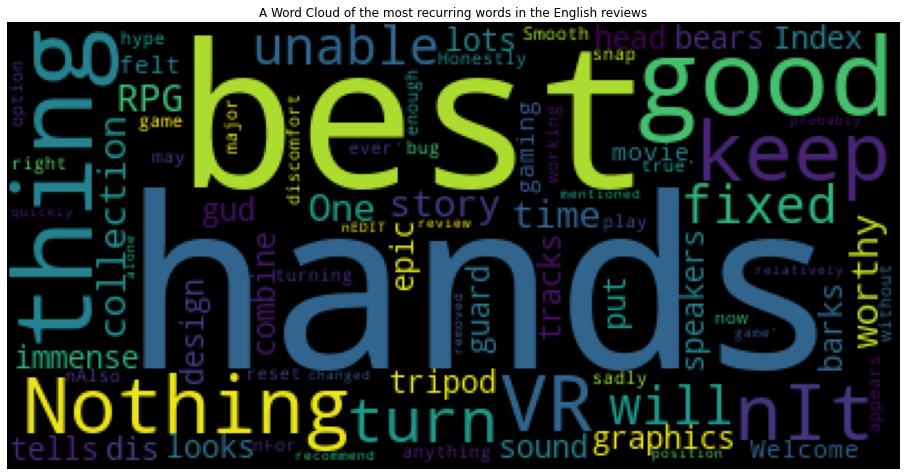

In [ ]:
# analysis computed only on the Kaggle dataframe
from wordcloud import WordCloud

english = df.loc[df['language'] == "english"]

text = english['review'].values 

wordcloud = WordCloud().generate(str(text))
plt.figure(figsize=(16,10))

plt.imshow(wordcloud)
plt.axis("off")

plt.title("A Word Cloud of the most recurring words in the English reviews")

plt.show()

In [ ]:
pd.options.display.max_colwidth = 1000
df[df['review'].str.contains('hands', na=False)]["review"]


598                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 Been a gamer all my life and this one is the best ive played hands d

The **Word Cloud** helps us visualize the words that appear the most within English written reviews. \\
We see, in particular, words related to the world of videogames like  "*graphics*", "*turn*", "*design*", "*play*", "*rpg*", etc., or words like "*good*", "*best*" and "*worthy*", typical of "reviews' language". Interesting is the case of the word "*hands*", which seems to be the most recurring one of all. Upon further inspection, it turns out that many of the reviews containing this substring actually contain the English expression "*hands down*", synonym of "easily" (see above, "*this one is the best ive played hands down*" or "*WOW just WOW hands down best game i have ever played*". \\
Also, we see words like "*one*", "*thing*", "*it*", "*enough*", which have no particular meaning and are present in the Word Cloud for the sole reason that we did not define a dictionary of common words to eliminate them as stopwords.

\\

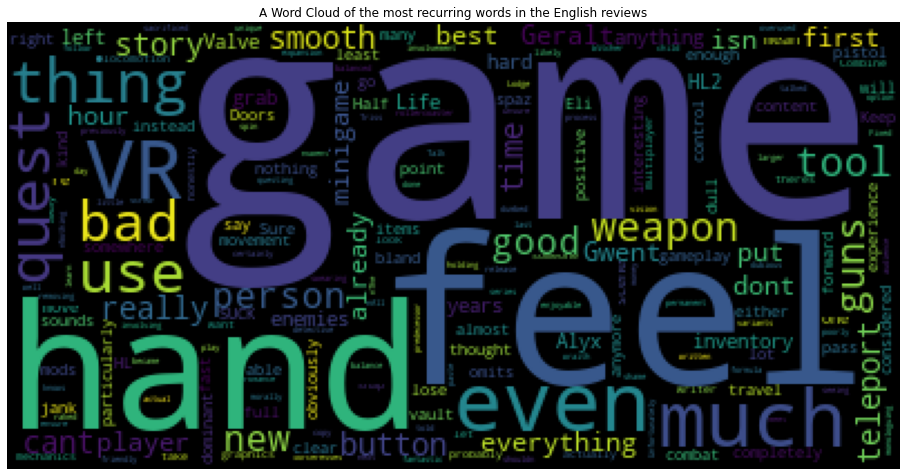

In [ ]:
# analysis computed only on the Kaggle dataframe
# look only at negative reviews written in English

english = df.loc[(df['language'] == "english")& (df["recommended"] == False)]

text = english['review'].values 

wordcloud = WordCloud().generate(str(text))
plt.figure(figsize=(16,10))

plt.imshow(wordcloud)
plt.axis("off")

plt.title("A Word Cloud of the most recurring words in the English reviews")

plt.show()

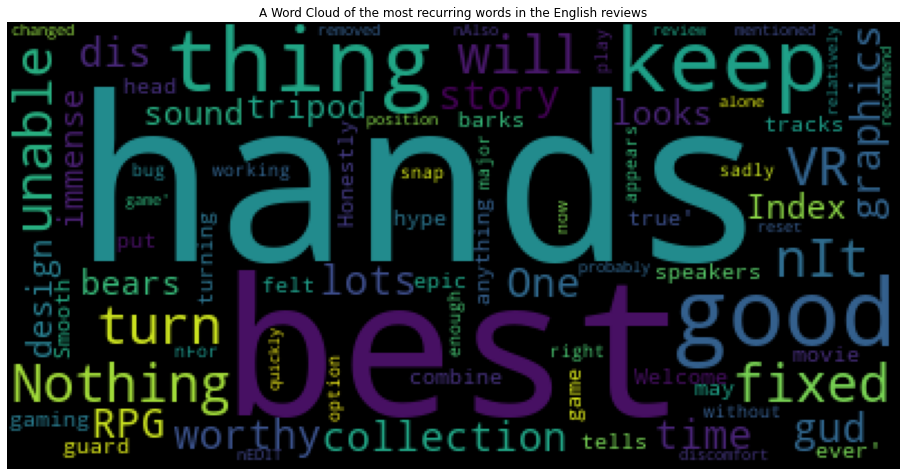

In [ ]:
# analysis computed only on the Kaggle dataframe
# look only at positive reviews written in English

english = df.loc[(df['language'] == "english") & (df["recommended"] == True)]

text = english['review'].values 

wordcloud = WordCloud().generate(str(text))
plt.figure(figsize=(16,10))

plt.imshow(wordcloud)
plt.axis("off")

plt.title("A Word Cloud of the most recurring words in the English reviews")

plt.show()

If we divide our Word Cloud based on positive and negative reviews, we notice that the positive Word Cloud does not change much and presents just about the same words as the first Word Cloud (that is, we find again words like "*hands*", "*good*", "best" ,etc.). This should probably be linked to the fact that most reviews are positive, as shown in the piechart below. As for the most common words in negative reviews, instead, it is possible to observe that their focus is on the "*game*" and on what the players "*feel*". Also, the word "*bad*" appears (which we do not see in the positive plot).

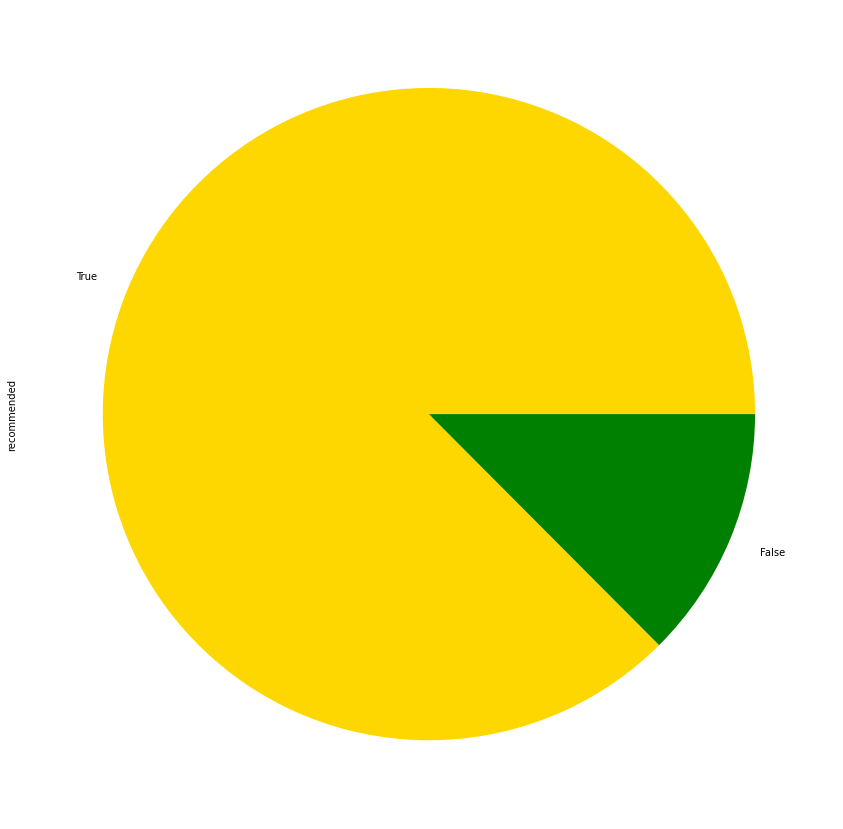

In [ ]:
df.recommended.value_counts().plot(kind='pie', colors = ["gold", "green"], figsize=(15,15))